#### __Predicting the Minimum Offer Price of Electronics Sold by an E-commerce Platform__ ####

#### __Data Processing__ #####

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

In [8]:
# Load the raw data into a dataframe
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
df = pd.read_csv(os.path.join(data_path, 'raw_data.csv'))

def preprocess_and_anonymise(df):
    # Drop irrelevant columns
    cols_to_drop = ['Unnamed: 0', 'asin', 'currency', 'product_url', 'product_photo', 'delivery', 'has_variations', 'sales_volume',
                    'product_availability', 'product_badge', 'book_formats' , 'coupon_text' , 'book_format' , 'product_byline', 'climate_pledge_friendly']
    
    df = df.drop(cols_to_drop, axis=1)

    # Rename brand identifiable columns
    anonymise_cols = {'is_prime': 'is_fast_shipping', 'is_amazon_choice': 'is_recommended'}
    
    df = df.rename(columns=anonymise_cols)

    # Convert all columns to lowercase
    df.columns = df.columns.str.lower()

    return df


# Preprocess and anonymise brand-specific data
df = preprocess_and_anonymise(df)

In [10]:
# Check for missing values
df.isnull().sum()

product_title                    0
product_price                    3
product_original_price         600
product_star_rating             51
product_num_ratings              0
product_num_offers               0
product_minimum_offer_price      3
is_best_seller                   0
is_recommended                   0
is_fast_shipping                 0
product                          0
dtype: int64

In [12]:
df.columns

Index(['product_title', 'product_price', 'product_original_price',
       'product_star_rating', 'product_num_ratings', 'product_num_offers',
       'product_minimum_offer_price', 'is_best_seller', 'is_recommended',
       'is_fast_shipping', 'product'],
      dtype='object')

**Observation**
- Drop the records where the target variable 'product_minimum_offer_price' is null
- Impute missing 'Product_original_price' with the 'product_price'
- Examine the feasibility of imputing missing 'product_star_rating' values with the average rating per product category, taking into account the sensitivity to outliers. Use Median if outliers are present


In [15]:
# Data Types
df.dtypes

product_title                   object
product_price                   object
product_original_price          object
product_star_rating            float64
product_num_ratings              int64
product_num_offers               int64
product_minimum_offer_price     object
is_best_seller                    bool
is_recommended                    bool
is_fast_shipping                  bool
product                         object
dtype: object

In [17]:
# Convert both product_price / product_original_price / product_minimum_offer_price to floats removing the pound sign
def process_pricing_columns(df, cols):
    df[cols] = df[cols].apply(lambda x: x.str.replace('[,£]', '', regex=True)).astype(float)
    return df

price_cols = ['product_minimum_offer_price', 'product_original_price', 'product_price']

df = process_pricing_columns(df, price_cols)

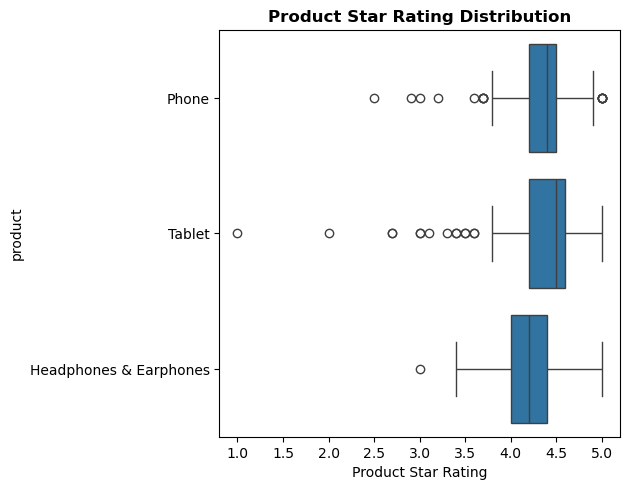

In [19]:
# Drop the records where the target variable 'product_minimum_offer_price' is null
df = df[~df['product_minimum_offer_price'].isnull()]

# Convert this for 3
# Product_star_rating - Investigate whether imputing the missing values with the average 'product_star_rating' per product category would work depending on presence of outliers
# Plot the Product star rating per Product type
sns.boxplot(data=df, x= 'product_star_rating',y= 'product')
plt.tight_layout()
plt.title('Product Star Rating Distribution', weight='bold')
plt.xlabel('Product Star Rating')
plt.show()

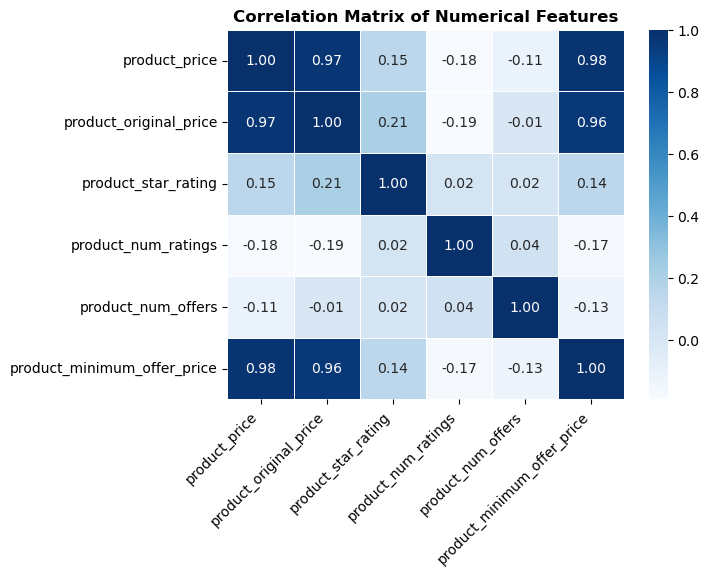

In [21]:
# Plot a heatmap of the correlation coefficients for all numerical variables
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True,  fmt=".2f", linewidth=.5, cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix of Numerical Features', weight='bold', fontsize=12);

In [23]:
# Given the multicollinearity between Product price and Product original price, create a new feature variable which extracts the discount rate (normalised)
df['product_original_price'] = np.where(df['product_original_price'].isnull(), df['product_price'], df['product_original_price'])

df['discount_rate'] = (df['product_original_price'] - df['product_price']) / df['product_original_price']

# Drop original features
df.drop(['product_price', 'product_original_price'], axis=1, inplace=True)

df.shape

(917, 10)

In [25]:
# Create two new feature varriables
# Storage capacity - set to 0 for headphones
# 'Has storage' Flag: The flag 'has_storage' captures the fact that storage is relevant for some products and irrelevant for others

def get_storage_capacity(df, title_col):
    match_1 = df[title_col].str.findall(r'\d{1,3}\s?[Gg][Bb|o]|\d{1,2}\s?[Tt][Bb]')
    match_2 = df[title_col].str.findall(r'\b(8|16|32|64|128|256|512)\b')

    combined_matches = [a + b for a, b in zip(match_1, match_2)]

    pattern = r'(\d{1,2})\s?(TB)'
    conversion = []
    for item in combined_matches:
        sublist = []
        for strings in item:
            match = re.search(pattern, strings)
            if match:
                sublist.append(int(match.group(1)) * 1024)
            else:
                sublist.append(int(re.match(r'\d*',strings).group()))
    
        conversion.append(sublist)
    
    storage_capacity = [max(storage) if storage else 0 for storage in conversion] 

    return storage_capacity

df['storage_capacity'] = get_storage_capacity(df, 'product_title')

df['has_storage'] = np.where(df['storage_capacity'] == 0, 0, 1)

In [37]:
# Extract a list of all brand names from the query parameters via the Config file
path = os.path.dirname(os.getcwd())
with open(os.path.join(path,'config.json')) as config_file:
    config = json.load(config_file)

def get_brand_name(config):
    # Combine all brands across the three product categories into one consolidated list
    brands = []
    for category, params in config['Product'].items():
        brands.extend(params['brand'].replace(',','').split())
    return set(brands)

brands = list(get_brand_name(config))

In [39]:
# Use Regex to extract the brand name from the Product title

results = [re.findall(r'|'.join(brands),l,flags=re.IGNORECASE)[0:1] for l in df['product_title']]

df['brand'] = [item[0] if item else np.nan for item in results]

# Drop the 20 records where 'brand' is null
nulls = len(df[df['brand'].isnull()])
print(f"Dropping {nulls} records due to missing brand information")

df = df[~df['brand'].isnull()]

Dropping 20 records due to missing brand information


In [41]:
# Create a rules based framework to filter erroneous accessories data i.e. Keyboards/Cases/Covers  - preferential treatment of false positive over false negatives
def filter_invalid_data(df):
    # Cases/Covers
    df = df[~((df['product_title'].str.contains(r'\bCase for\b', case=False, regex=True)) | 
            (df['product_title'].str.contains(r'\bCover\b', case=False, regex=True) & 
              df['product_title'].str.contains(r'\bcompatible with\b', case=False, regex=True)))]
    # Keyboards
    df = df[~((df['product_title'].str.contains(r'\bKeyboard\b', case=False, regex=True)) &
            (df['product_title'].str.contains(r'\bcompatible with\b', case=False, regex=True) |
             df['product_title'].str.contains(r'\bfor\b', case=False, regex=True)))]

    return df

df = filter_invalid_data(df)



In [43]:
# Drop the product title as it is no longer relevant for feature analysis
df.drop('product_title', axis=1, inplace=True)

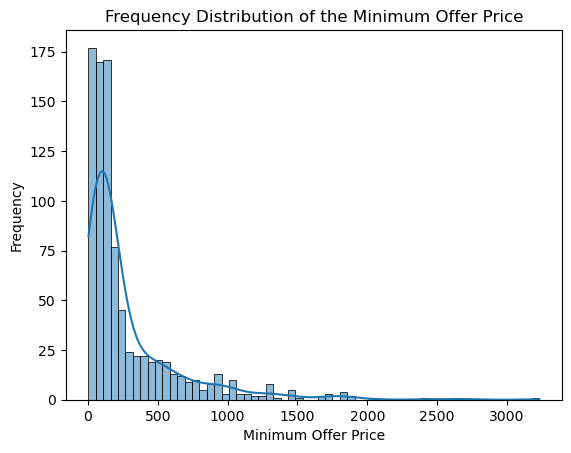

In [45]:
# Plot a histogram of the 'Product_minimum_offer_price' to ascertain distribution  - Feature 
sns.histplot(data=df, x= 'product_minimum_offer_price',kde=True)
plt.ylabel('Frequency')
plt.title('Frequency Distribution of the Minimum Offer Price')
plt.xlabel('Minimum Offer Price');

**Observation**: 
- Heavily right skewed distribution, will require a log transformation to normalise the distribution.
- To understand the distribution per Product type, plot the frequency distribution of the target variable split by each product type.

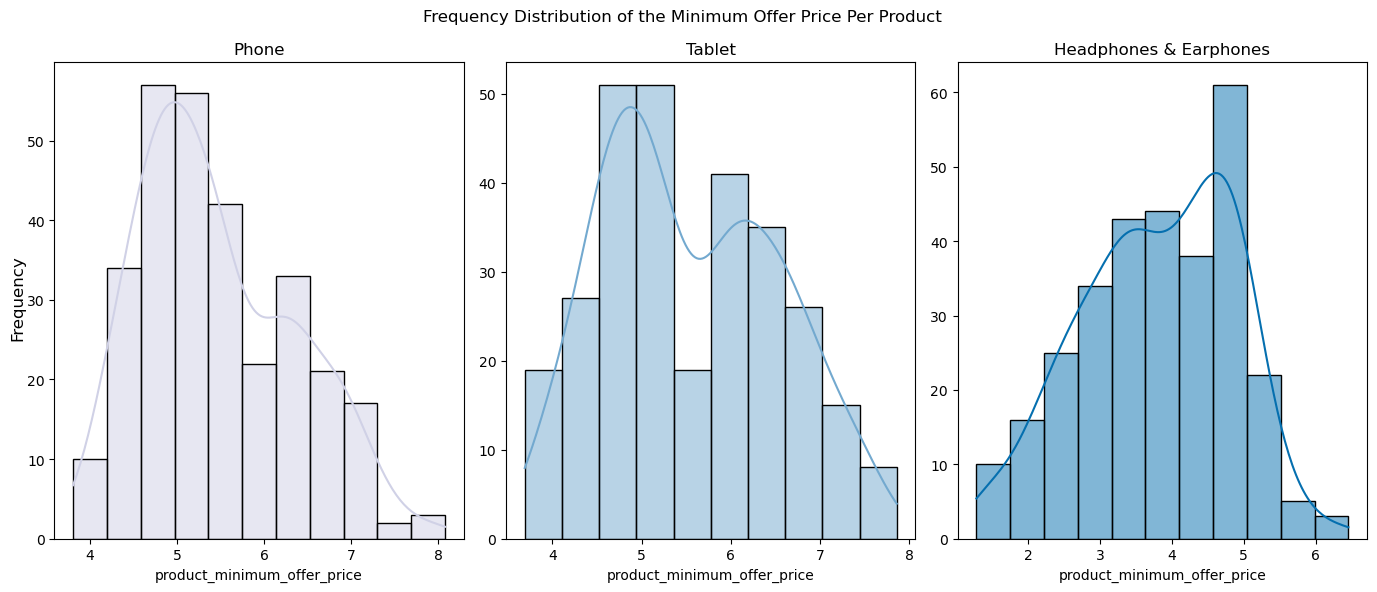

In [48]:
# Extract the number of unique Product types
products = df['product'].unique()

# Specify colour palette
palette = sns.color_palette('PuBu',n_colors=len(products))

# Plot the logarithmic minimum offer price per Product
fig, axes = plt.subplots(1, 3, figsize=[14,6])
for idx, product in enumerate(products):
    product_df = df[df['product'] == product]
    # Apply log transformation to the minimum offer price
    sns.histplot(data=product_df, x=np.log(product_df['product_minimum_offer_price']), kde=True, ax=axes[idx], color=palette[idx]) 
    axes[idx].set_ylabel('')
    axes[idx].set_title(product)

fig.supylabel('Frequency')
fig.suptitle('Frequency Distribution of the Minimum Offer Price Per Product')
plt.tight_layout();

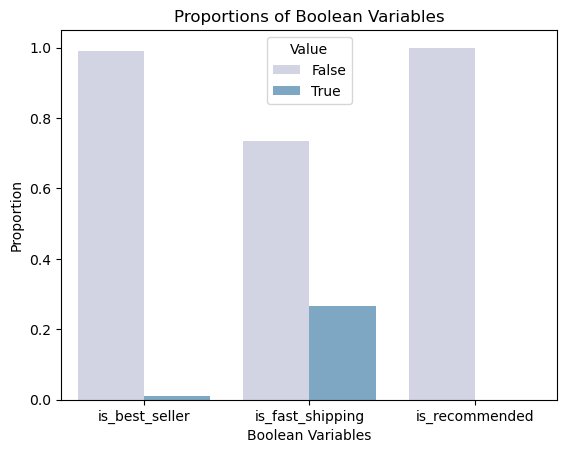

In [50]:
# Visualize the distribution of True/False values for boolean feature variables using a countplot to assess their usability in the regression model
bool_data = df.select_dtypes(include=['bool'])

melted_df = bool_data.melt(var_name='Boolean Variables', value_name = 'Value')
proportions = pd.DataFrame(melted_df.groupby('Boolean Variables')['Value'].value_counts(normalize=True)).reset_index()

sns.barplot(proportions, x= 'Boolean Variables', y='proportion', hue='Value', palette=palette[0:2])
plt.title('Proportions of Boolean Variables')
plt.ylabel('Proportion');

In [52]:
# Dropping is_recommended (no True values) and is_best_seller (99% False) due to minimal variance, as they will provide little predictive value to the model
df.drop(['is_recommended', 'is_best_seller'], axis=1, inplace=True)

Post Model Training - Feature Engineering
- Note: The following changes have been applied post model selection/training to improve the performance of the model

In [55]:
# Assuming X_train is your training dataset
Q1 = df['storage_capacity'].quantile(0.25)
Q3 = df['storage_capacity'].quantile(0.75)
IQR = Q3 - Q1

# Defining the outlier condition
outlier_condition = (df['storage_capacity'] < (Q1 - 1.5 * IQR)) | (df['storage_capacity'] > (Q3 + 1.5 * IQR))

df = df[~outlier_condition]

In [57]:
# Apply a log transformation to heavily right-skewed numerical features - 'product_num_ratings' and 'storage_capacity'# print(df[['product_num_ratings','storage_capacity']].agg(['min', 'max']))

df['log_product_num_ratings'] = np.log1p(df['product_num_ratings'])
df['log_storage_capacity'] = np.log1p(df['storage_capacity'])

df.drop(['product_num_ratings', 'storage_capacity'], axis=1, inplace=True)

In [59]:
# Create an interaction feature between product and brand, leveraging their high feature importance
df['product_x_brand'] = df['product'] + "_x_" + df['brand']


In [61]:
# Filter any brands which have a count smaller than 10
df = df[df.groupby('brand')['brand'].transform('count') >= 10]

In [66]:
# Save the processed df as a csv
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
df.to_csv(os.path.join(data_path,'clean_data.csv'), index=False)